# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [2]:
# Import Python libraries  
import json
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from PIL import Image

# Import PyTorch libraries
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

# Pretty display for Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Print Python version for future reference
print(sys.version)

3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0]


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
# Stats needed to normalize ImageNet images
means = [0.485, 0.456, 0.406]
std_devs = [0.229, 0.224, 0.225]
input_size = 224

# Other transforms parameters 
down_size = 256
rotation = 30

# Determine batch size for DataLoaders
_batch_size = 64

In [4]:
# Define transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(rotation),
                                 transforms.RandomResizedCrop(input_size),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(means,std_devs)]),
    'valid': transforms.Compose([transforms.Resize(down_size),
                                        transforms.CenterCrop(input_size),
                                        transforms.ToTensor(),
                                        transforms.Normalize(means,std_devs)]),
    'test': transforms.Compose([transforms.Resize(down_size),
                                        transforms.CenterCrop(input_size),
                                        transforms.ToTensor(),
                                        transforms.Normalize(means,std_devs)])
    }

# Build datasets and apply transforms (with ImageFolder)
image_datasets = {
    'train': datasets.ImageFolder('flowers/train/', 
                                  transform=data_transforms['train']),
    'valid': datasets.ImageFolder('flowers/valid/', 
                                  transform=data_transforms['valid']),
    'test': datasets.ImageFolder('flowers/test/', 
                                 transform=data_transforms['test'])
    }

# Define dataloaders
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], 
                                         batch_size=_batch_size, shuffle=True),
    'valid': torch.utils.data.DataLoader(image_datasets['valid'], 
                                         batch_size=_batch_size),
    'test': torch.utils.data.DataLoader(image_datasets['test'], 
                                        batch_size=_batch_size)
    }

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
# Open JSON file and store in dictionary 
with open('cat_to_name.json', 'r') as f:
    label_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [7]:
# Download and instantiate pre-trained network: VGG-11
#model = models.vgg11(pretrained=True)
model = models.densenet121(pretrained=True)

In [8]:
# Display VGG-11 network architecture
display(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [9]:
# Freeze updating of pre-trained parameters
for param in model.parameters():
    param.requires_grad = False

In [10]:
# Parameters 
in_features = 25088
out_categories = 102
layer_1 = 512

# Build classifier
classifier = nn.Sequential(OrderedDict([
    ('dropout1', nn.Dropout(0.5)),
    ('fc1', nn.Linear(in_features, layer_1)),
    ('relu', nn.ReLU()),
    ('dropout2', nn.Dropout(0.5)),
    ('fc2', nn.Linear(layer_1, out_categories)),
    ('output', nn.LogSoftmax(dim=1))
    ]))

# Assign new classifier to VGG-11 architecture 
model.classifier = classifier

In [11]:
# Instantiate loss function
loss_function = nn.NLLLoss()

# Instantiate optimization algorithm 
learning_rate = 0.0001
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

# Enable CUDA: use GPUs for model computation
if torch.cuda.is_available():
    model.to('cpu')

/home/gerie/Documents/python/flask_app/venv/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


Define parameters for the training loop. 

In [13]:
# Epochs: number of iterations over the entire training dataset
epochs = 6
# Number of iterations between printing loss and accuracy 
print_steps = 30

In [14]:
%%time

# Initialize steps
step = 0

# Iterate over number of epochs
for e in range(epochs):
    running_loss = 0 

    # Iterate over the entire training dataset
    # one batch per iteration 
    for input_images, labels in dataloaders['train']:
        step += 1     
        
        # Enable CUDA: use GPUs for model computation
        if torch.cuda.is_available():
            inputs, labels = inputs.to('cpu'), labels.to('cpu')   
        
        # Clear the gradients of all optimized tensors
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model.forward(input_images)
        loss = loss_function(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate and print running training loss
        running_loss += loss.item()       
        if step % print_steps == 0:
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_steps))
            running_loss = 0
        
print('\nCount of data batches seen:  {} \n'.format(step))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x1024 and 25088x512)

>**Running loss over training cycles:**

    Epoch: 1/6...  Loss: 2.5249
    Epoch: 1/6...  Loss: 2.2719
    Epoch: 1/6...  Loss: 2.1266
    Epoch: 2/6...  Loss: 1.0807
    Epoch: 2/6...  Loss: 1.6770
    Epoch: 2/6...  Loss: 1.6962
    Epoch: 3/6...  Loss: 0.2008
    Epoch: 3/6...  Loss: 1.5353
    Epoch: 3/6...  Loss: 1.4367
    Epoch: 3/6...  Loss: 1.3798    
    Epoch: 4/6...  Loss: 1.2882
    Epoch: 4/6...  Loss: 1.2619
    Epoch: 4/6...  Loss: 1.2889
    Epoch: 5/6...  Loss: 1.1873
    Epoch: 5/6...  Loss: 1.1387
    Epoch: 5/6...  Loss: 1.1314
    Epoch: 6/6...  Loss: 1.0716
    Epoch: 6/6...  Loss: 1.0607
    Epoch: 6/6...  Loss: 1.0139

    Count of data batches seen:  618 

In [15]:
# Initialize validation counters
validation_correct = 0
validation_total = 0

# no_grad() prevents tracking history (and using memory)
with torch.no_grad(): 
    
    # Iterate over the entire validation dataset
    for input_images, labels in dataloaders['valid']:
        
        # Enable CUDA: use GPUs for model computation
        if torch.cuda.is_available():
            input_images, labels = input_images.to('cuda'), labels.to('cuda')
        
        # Make predictions 
        outputs = model(input_images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Count total and correct predictions
        validation_total += labels.size(0)
        validation_correct += (predicted == labels).sum().item()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x1024 and 25088x512)

In [16]:
# Print validation accuracy
print('Validation accuracy ({0:d} validation images): {1:.1%}'
      .format(validation_total, validation_correct / validation_total))

ZeroDivisionError: division by zero

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [17]:
# Initialize test counters
test_correct = 0
test_total = 0

# no_grad() prevents tracking history (and using memory)
with torch.no_grad(): 
    
    # Iterate over the entire validation dataset
    for input_images, labels in dataloaders['test']:
        
        # Enable CUDA: use GPUs for model computation
        #if torch.cuda.is_available():
        input_images, labels = input_images.to('cpu'), labels.to('cpu')
        
        # Make predictions 
        outputs = model(input_images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Count total and correct predictions
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x1024 and 25088x512)

In [ ]:
print('Testing accuracy ({0:d} test images): {1:.1%}'
      .format(test_total, test_correct / test_total))

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [18]:
# Save the mapping of the flower labels (1-102) to array indices (0-101)
model.class_to_idx = image_datasets['train'].class_to_idx

In [21]:
## Loading the checkpoin

#At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [22]:
# Create dictionary with needed components to rebuild model
checkpoint = {
    'model': model,
    'epochs': epochs,
    'optimizer_state': optimizer.state_dict,
    'labels_to_flower_names': label_to_name
    }

# Save checkpoint
torch.save(checkpoint, 'checkpoint_05-15-2019.pth')

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [23]:
# Stats needed to normalize ImageNet images
ImageNet = {
    'means' : np.array([0.485, 0.456, 0.406]),
    'std_devs' : np.array([0.229, 0.224, 0.225]),
    'short_ax_max' : 255,
    'resize' : 224
    }

In [24]:
# Process a PIL image for use in a PyTorch model
def process_image(pil_image, image_reqs=ImageNet):
    """Scale, crop, and normalize a PIL image for a PyTorch model.
    Returns a NumPy array
    
    Args:
       pil_image (PIL image): Input image for a prediction task 
       image_reqs (dict): Image stats needed so image matches model reqs
    Returns:
        NumPy array
    
    """
    # Resize image so that shortest side is 256 pixels, keeping ratio
    img_size = pil_image.size
    ratio = max(img_size) / min(img_size)
    new_size = [0, 0]
    short = img_size.index(min(img_size))
    long = 1 - short 
    new_size[short] = image_reqs['short_ax_max']
    new_size[long] = int(image_reqs['short_ax_max'] * ratio)
    pil_image = pil_image.resize(size=tuple(new_size))
    
    # Crop out the center 224x224 portion of the image
    gap_x = int((new_size[0] - image_reqs['resize']) / 2)
    gap_y = int((new_size[1] - image_reqs['resize']) / 2)
    crop_box = (gap_x, gap_y, gap_x + image_reqs['resize'], 
                gap_y + image_reqs['resize']) 
    pil_image = pil_image.crop(box=crop_box)
    
    # Re-encode image color channels
    np_image = np.array(pil_image) / 255
    
    # Normalize image accordingly to the same statistics used to train 
    norm_image = (np_image - image_reqs['means']) / image_reqs['std_devs']
    
    # Reorder dimensions of NumPy array so it matches PyTorch's input
    norm_image = norm_image.transpose((2, 0, 1))
    
    return norm_image

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [43]:
# Load a flower image and make a prediction of the top-K classes
def predict(img_filepath, model, topk=5):
    ''' Predict the top-K classes of an image using a trained 
    deep learning model.
    
    Args:
       img_filepath (str): Input image for the prediction task 
       model (torchvision.models): Trained deep learning model
       topk (int): Number of top most likely predictions
    Returns:
        top_probs (list)
        classes (list)
    
    '''
    # Open PIL image
    pil_image = Image.open(img_filepath)
    # Scale, crop, normalize PIL image
    np_image = process_image(pil_image, image_reqs=ImageNet) 
    
    # Resize NumPy array to match dataloader output
    np_image = np.resize(np_image,(1, 3, 224, 224))
    # Covert NumPy array to PyTorch tensor
    img_tensor = torch.from_numpy(np_image).type(torch.FloatTensor)

    # Enable CUDA: use GPUs for model computation
    if torch.cuda.is_available():
        img_tensor = img_tensor.to('cuda')
    
    # Run model in evaluation mode 
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
    
    # Convert softmax output to probabilities
    probs = torch.exp(outputs.data)
    
    # Find top-k probabilities and indices 
    top_probs, indices = torch.topk(probs, dim=1, k=topk)
    
    # Convert PyTorch tensors to lists
    top_probs, indices = top_probs.to('cpu').numpy(), indices.to('cpu').numpy()
    top_probs, indices = top_probs[0].tolist(), indices[0].tolist()
    
    # Find the class using the indices (reverse dictionary first)
    idx_to_class = {idx: class_ for class_, idx in model.class_to_idx.items()}
    classes = [idx_to_class[i] for i in indices]

    return top_probs, classes    

In [26]:
# Choose a flower category and individual image for prediction example
test_class = '74'
pathname = os.path.join(os.getcwd(),'flowers/test/1/1.png')

# Run predict() to get model predictions: top-k classes and probabilities 
probs, classes = predict(pathname, model, topk=5)

NameError: name 'predict' is not defined

#### Get flower names from checkpoint dictionary

In [57]:
# Get the flower-category names from the saved checkpoint
flower_names = checkpoint['labels_to_flower_names']
test_flower_name = flower_names[test_class]
top_k_names = [flower_names[key] for key in classes] 

NameError: name 'classes' is not defined

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [28]:
def imshow(image, ax=None, title=None, image_reqs=ImageNet):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = image_reqs['means']
    std = image_reqs['std_devs']
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)

#### 

In [30]:
def sanity_checking():    
    # Create figure and axes 
    fig, (flower, prob_bars) = plt.subplots(nrows=2, ncols=1, figsize=(6,8))

    # Render the flower image
    imshow(image=process_image(Image.open(pathname)), ax=flower)

    flower.set_title('Test flower category:\n— {} —'.format(test_flower_name), 
                     fontsize=16)

    # Make barchart of top-k probabilities 
    index = np.arange(len(classes))[::-1]
    prob_bars.barh(index, probs, tick_label=top_k_names, align='center')
    prob_bars.set_title('Model prediction', fontsize=14)
    prob_bars.set_xlabel('Probability', fontsize=12)
    prob_bars.set_ylabel('Top-K classes', fontsize=12)

    # Plot the final figure
    fig.tight_layout()

FileNotFoundError: [Errno 2] No such file or directory: '/home/gerie/Desktop/austine/aipnd-project/flowers/test/1/1.png'

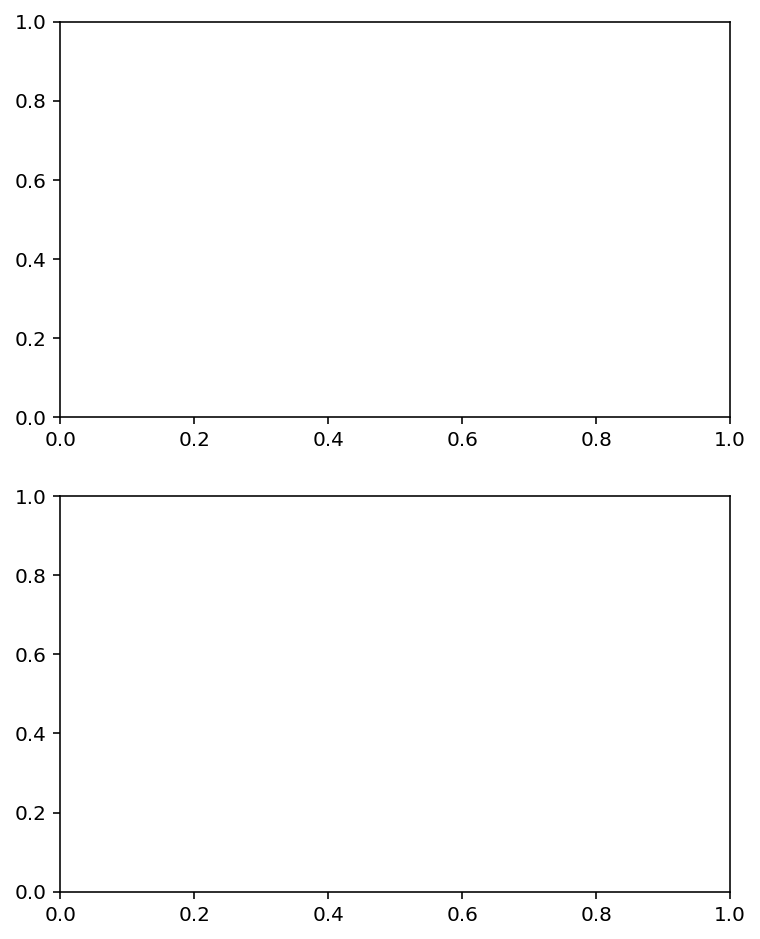

In [31]:
sanity_checking()